In [70]:
# python visualize_dataset.py \
#   --data-dir /media/NAS_179_2_josh_2/snu-pni-decoding/E003_12weeks_labelled_raw_data_251116 \
#   --window-size 1000 --stride 1000 \
#   --normalize-per-csv \
#   --percentile-range 1 99 \
#   --no-percentile-clip \
#   --activity-sigma-mult 1.0 \
#   --resting-labels resting \
#   --num-windows 3 \
#   --output-dir /media/NAS_179_2_josh_2/snu-pni-decoding/analysis/dataloader_visualization \
#   --trials E003_10W_Trial1_labelled_raw_data_.csv

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

# ---------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------
data_dir = Path("/media/NAS_179_2_josh_2/snu-pni-decoding/E003_12weeks_labelled_raw_data_251116")
output_dir = Path("/media/NAS_179_2_josh_2/snu-pni-decoding/analysis/label_raster_plots")
output_dir.mkdir(parents=True, exist_ok=True)

sample_num = 50        # Number of signals to plot per label
random_state = 42      # Controls which samples are selected when sampling
vertical_scale = 1.5   # Spacing multiplier to separate stacked traces
activity_sigma_mult = 1.0  # Samples beyond mean +/- (mult * std) count toward activity
min_spike_count = 20        # Minimum samples exceeding activity threshold per row
outlier_sigma_mult = 50.0   # Drop rows if any sample exceeds mean +/- (mult * std)
resting_labels = {"resting"}  # Labels exempt from activity filtering
y_lim_per_low = 1
y_lim_per_high = 99

# Collect CSV files and let the user choose one
csv_files = sorted(data_dir.glob("*.csv"))
csv_names = [path.name for path in csv_files]

print(f"Found {len(csv_files)} CSV files in {data_dir}")
for idx, name in enumerate(csv_names):
    print(f"  [{idx}] {name}")
print(f"\nPlots will be saved to {output_dir}\n")

# >>> Set this to the exact filename you want to plot <<<
target_csv_name = "E003_1W_Trial2_labelled_raw_data_.csv"  # <-- edit me

if target_csv_name not in csv_names:
    raise FileNotFoundError(
        f"'{target_csv_name}' not found in {data_dir}. Pick one of the listed files."
    )

target_csv = data_dir / target_csv_name
print(f"Current target CSV: {target_csv}")


Found 27 CSV files in /media/NAS_179_2_josh_2/snu-pni-decoding/E003_12weeks_labelled_raw_data_251116
  [0] E003_10W_Trial1_labelled_raw_data_.csv
  [1] E003_10W_Trial3_labelled_raw_data_.csv
  [2] E003_12W_Trial1_labelled_raw_data_.csv
  [3] E003_12W_Trial2_labelled_raw_data_.csv
  [4] E003_12W_Trial3_labelled_raw_data_.csv
  [5] E003_12W_Trial4_labelled_raw_data_.csv
  [6] E003_1W_Trial2_labelled_raw_data_.csv
  [7] E003_1W_Trial3_labelled_raw_data_.csv
  [8] E003_1W_Trial4_labelled_raw_data_.csv
  [9] E003_1W_Trial5_labelled_raw_data_.csv
  [10] E003_1W_Trial8_labelled_raw_data_.csv
  [11] E003_2W_Trial13_labelled_raw_data_.csv
  [12] E003_2W_Trial14_labelled_raw_data_.csv
  [13] E003_2W_Trial1_labelled_raw_data_.csv
  [14] E003_2W_Trial4_labelled_raw_data_.csv
  [15] E003_4W_Trial11_labelled_raw_data_.csv
  [16] E003_4W_Trial6_labelled_raw_data_.csv
  [17] E003_4W_Trial7_labelled_raw_data_.csv
  [18] E003_5W_Trial10_labelled_raw_data_.csv
  [19] E003_5W_Trial11_labelled_raw_data_.cs


Generating raster plots for E003_1W_Trial2_labelled_raw_data_.csv



Found 6 unique labels: ['resting' 'unassigned' 'walking' 'standing' 'climbing' 'grooming']
Label 'resting': 3675 rows -> 3673 after filtering


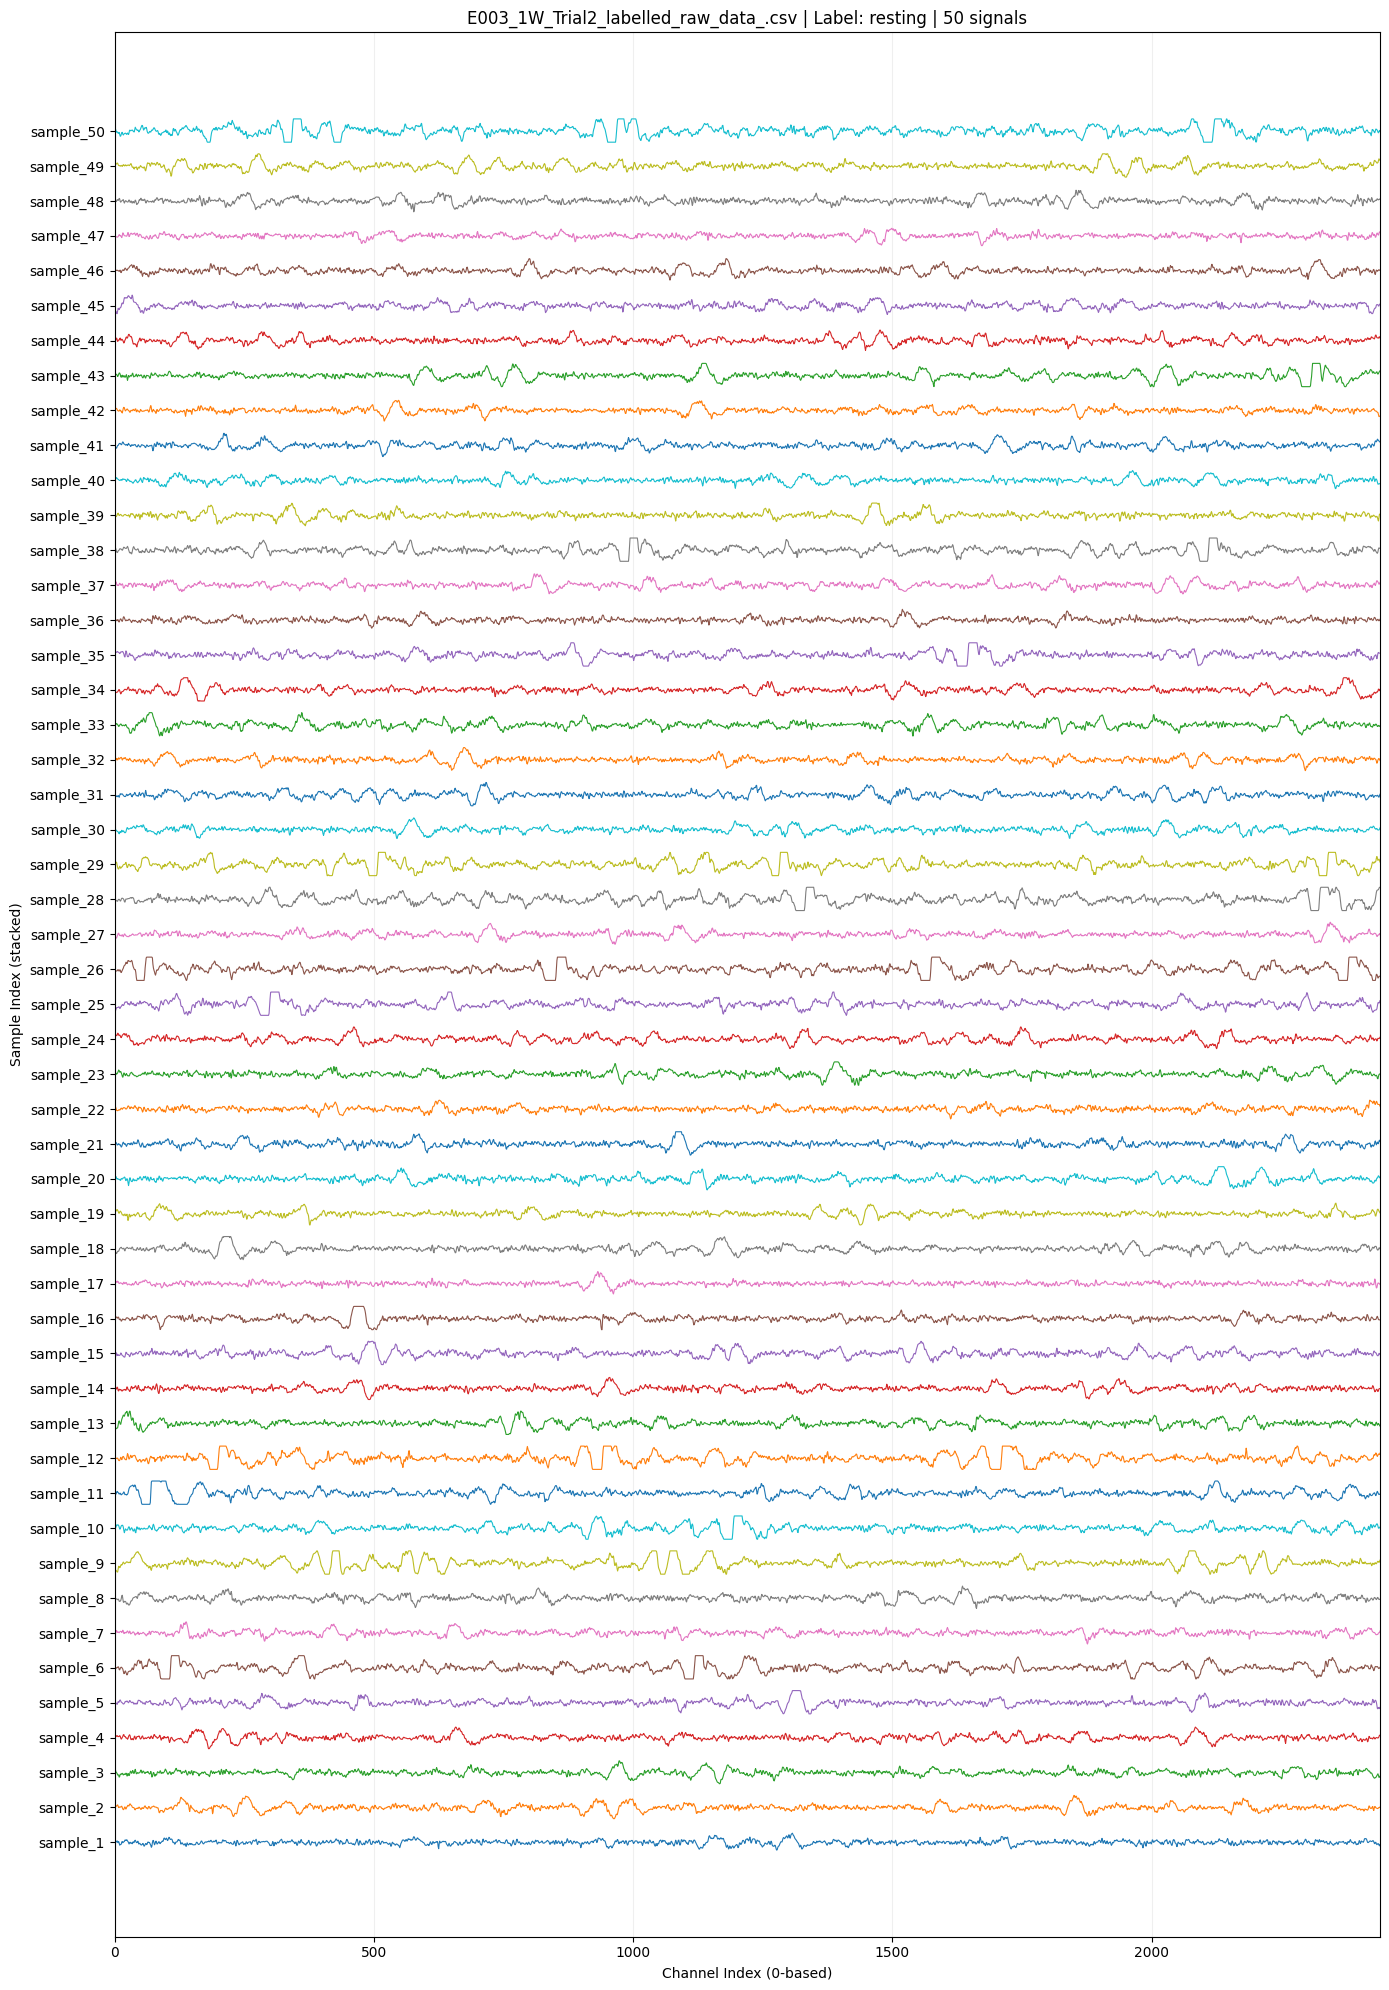

  Saved plot for label resting -> /media/NAS_179_2_josh_2/snu-pni-decoding/analysis/label_raster_plots/E003_1W_Trial2_labelled_raw_data__label-resting_raster.png
Label 'unassigned': 1160 rows -> 1147 after filtering


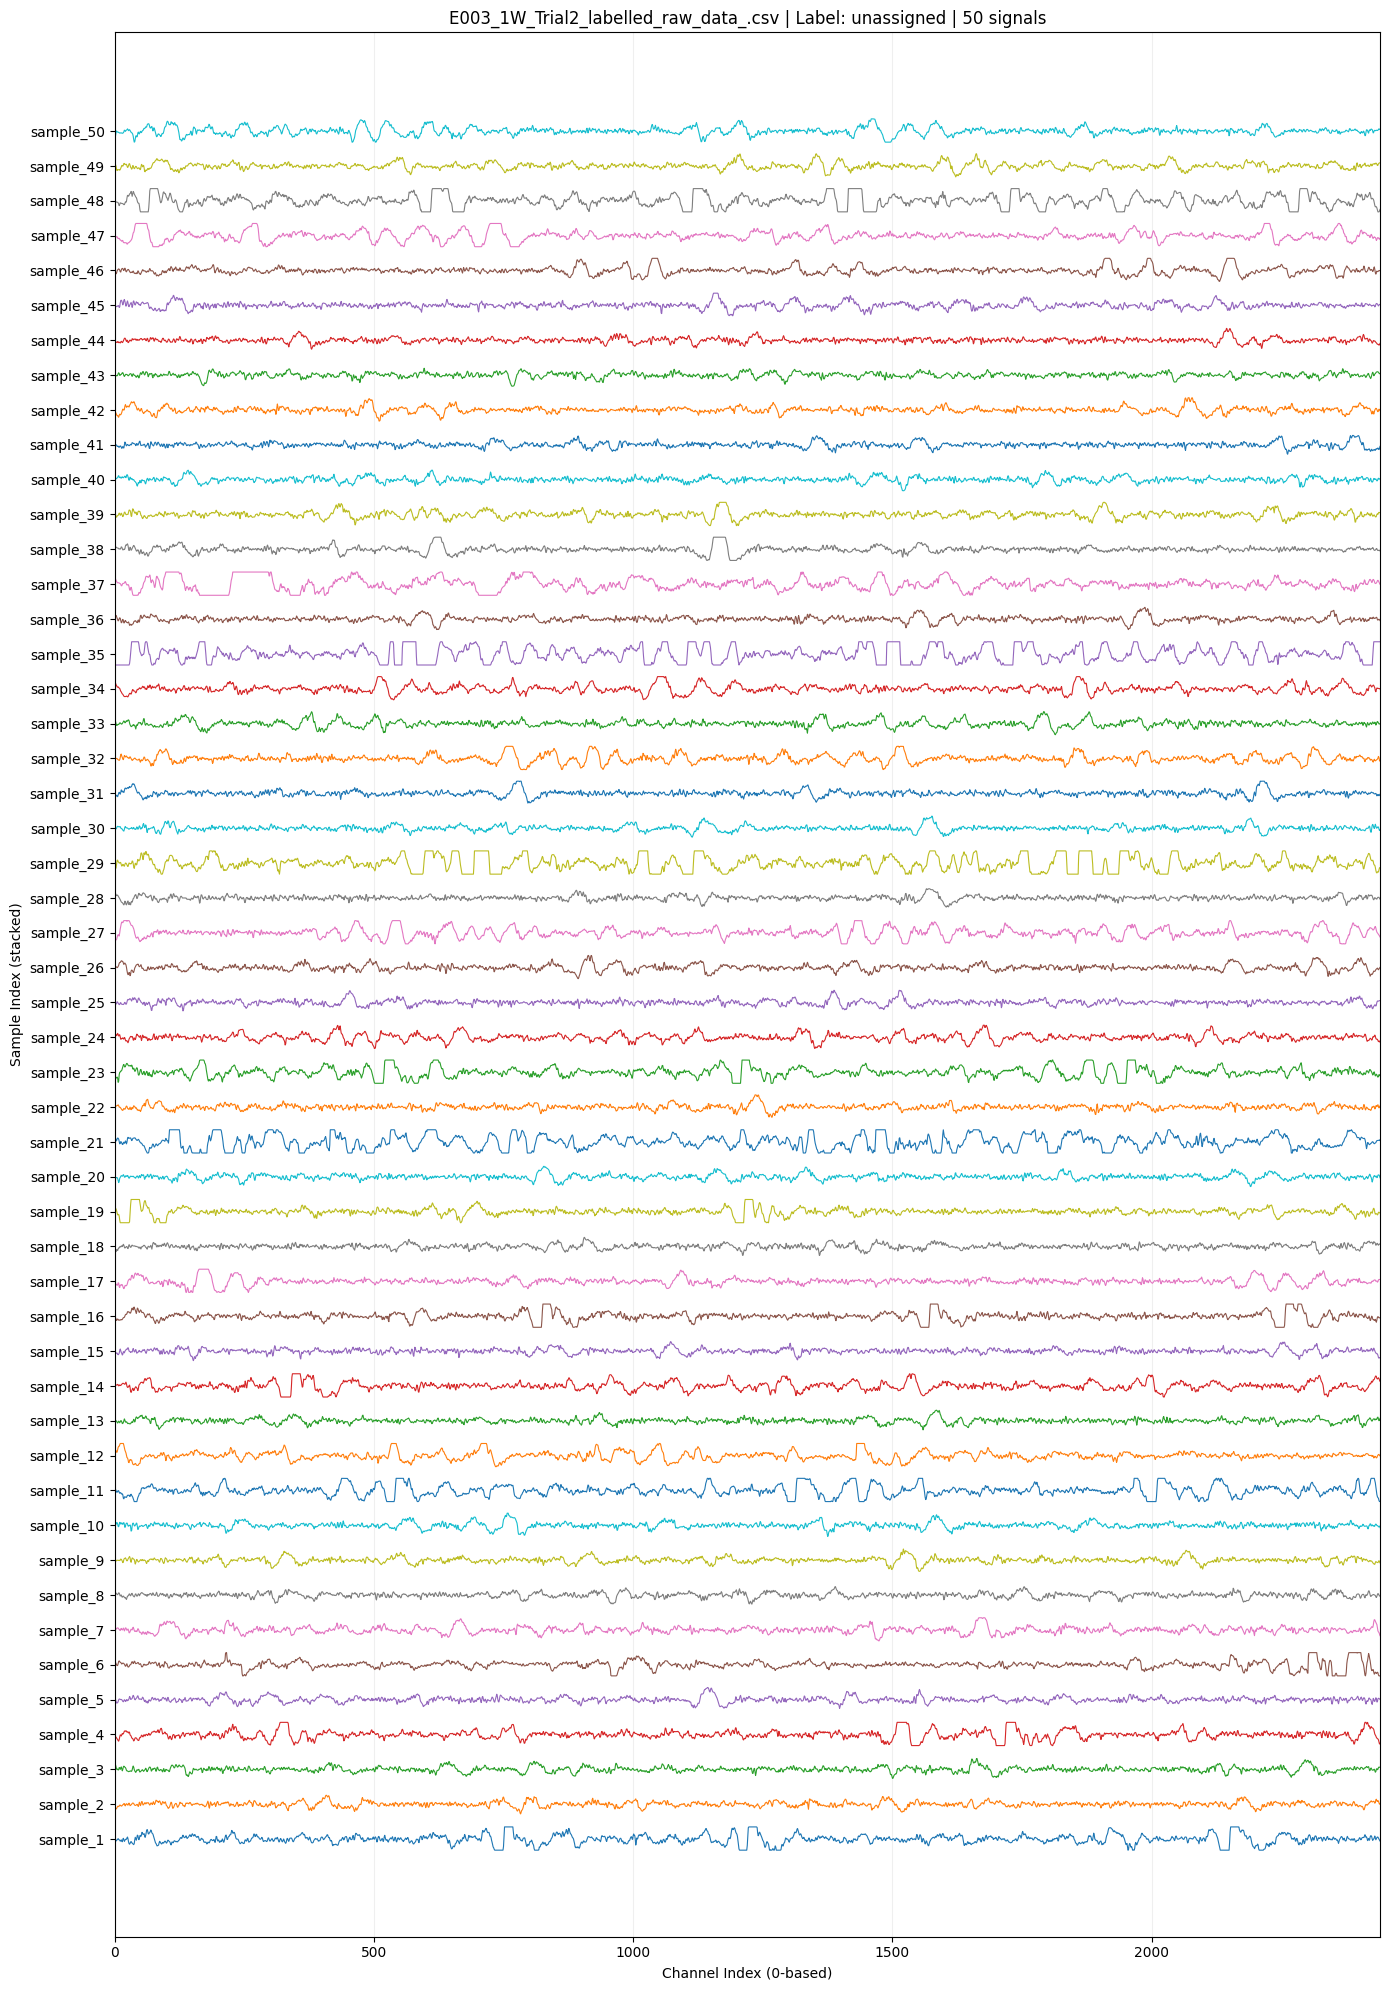

  Saved plot for label unassigned -> /media/NAS_179_2_josh_2/snu-pni-decoding/analysis/label_raster_plots/E003_1W_Trial2_labelled_raw_data__label-unassigned_raster.png
Label 'walking': 43 rows -> 35 after filtering


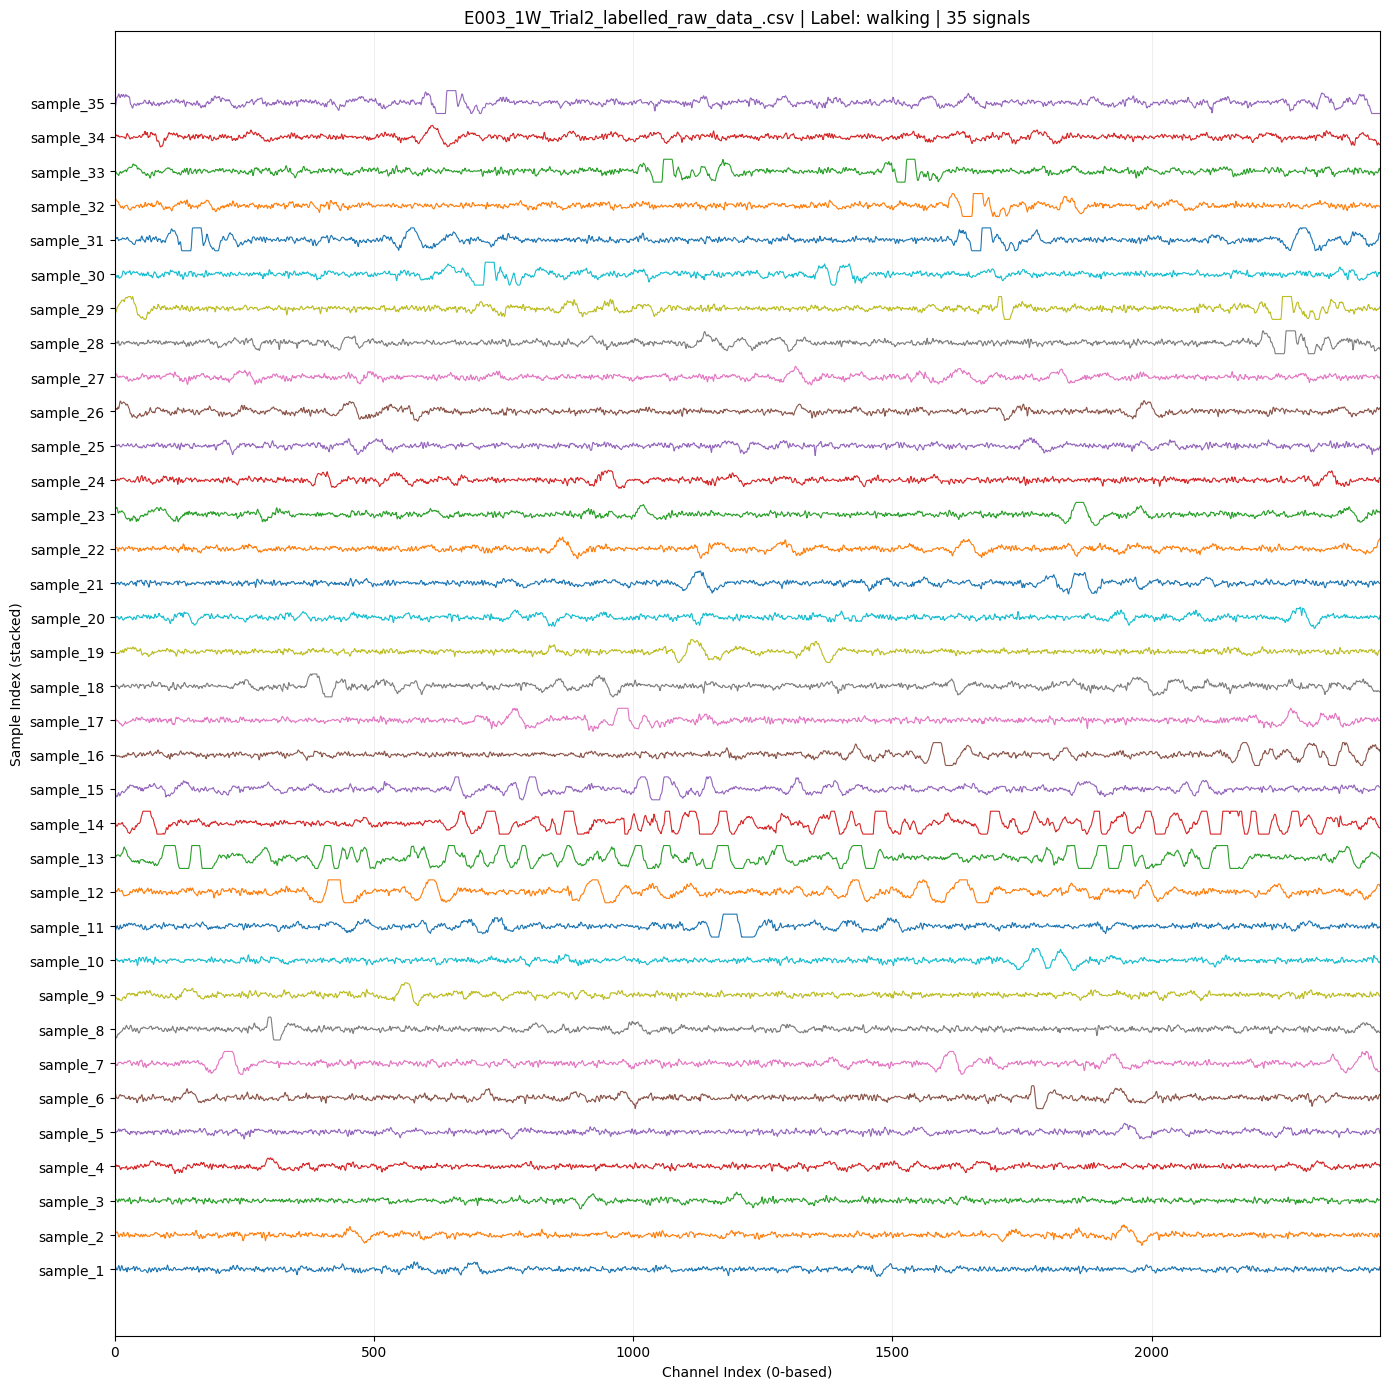

  Saved plot for label walking -> /media/NAS_179_2_josh_2/snu-pni-decoding/analysis/label_raster_plots/E003_1W_Trial2_labelled_raw_data__label-walking_raster.png
Label 'standing': 10 rows -> 10 after filtering


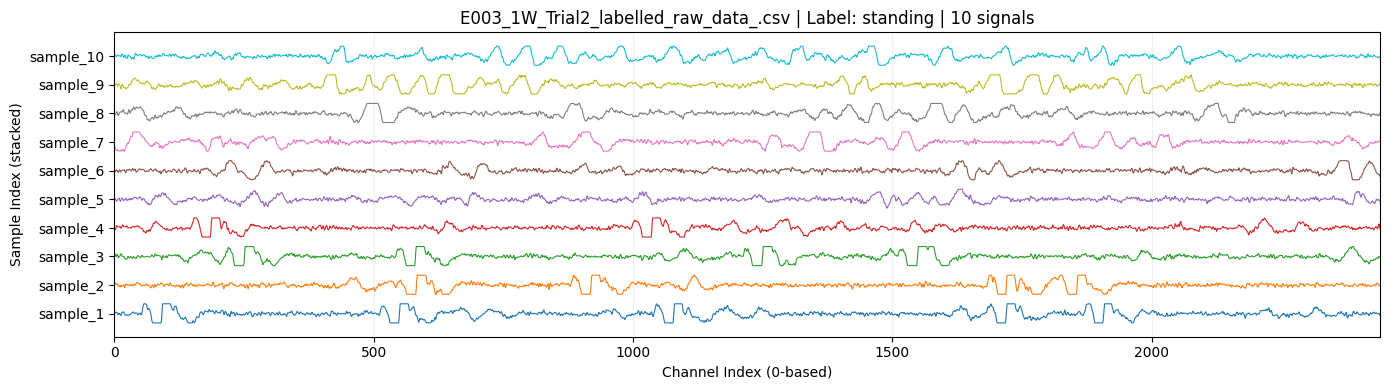

  Saved plot for label standing -> /media/NAS_179_2_josh_2/snu-pni-decoding/analysis/label_raster_plots/E003_1W_Trial2_labelled_raw_data__label-standing_raster.png
Label 'climbing': 72 rows -> 72 after filtering


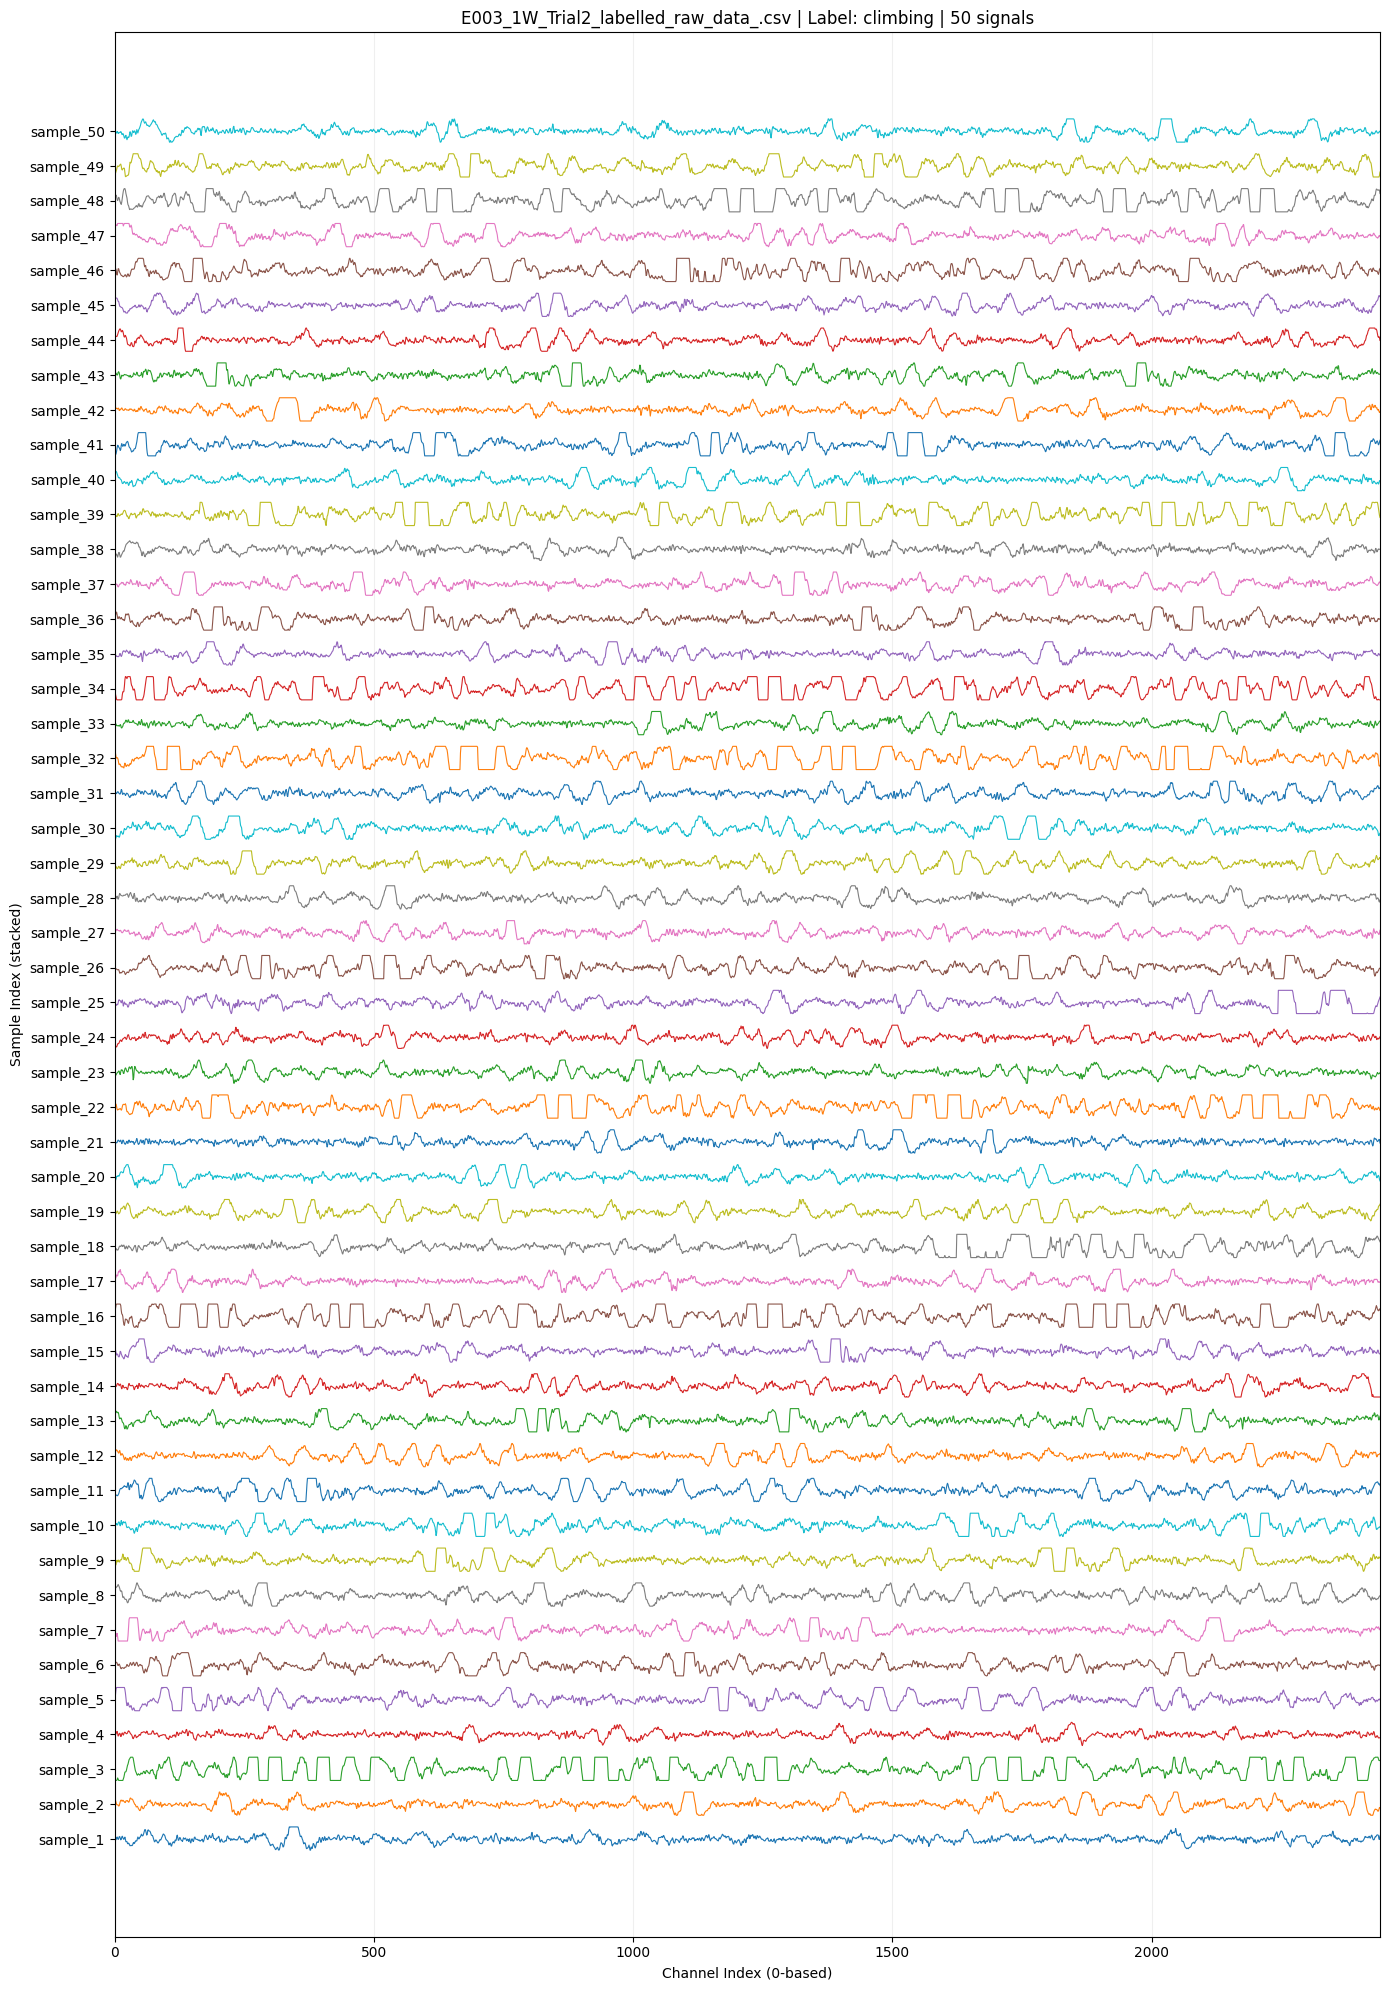

  Saved plot for label climbing -> /media/NAS_179_2_josh_2/snu-pni-decoding/analysis/label_raster_plots/E003_1W_Trial2_labelled_raw_data__label-climbing_raster.png
Label 'grooming': 197 rows -> 197 after filtering


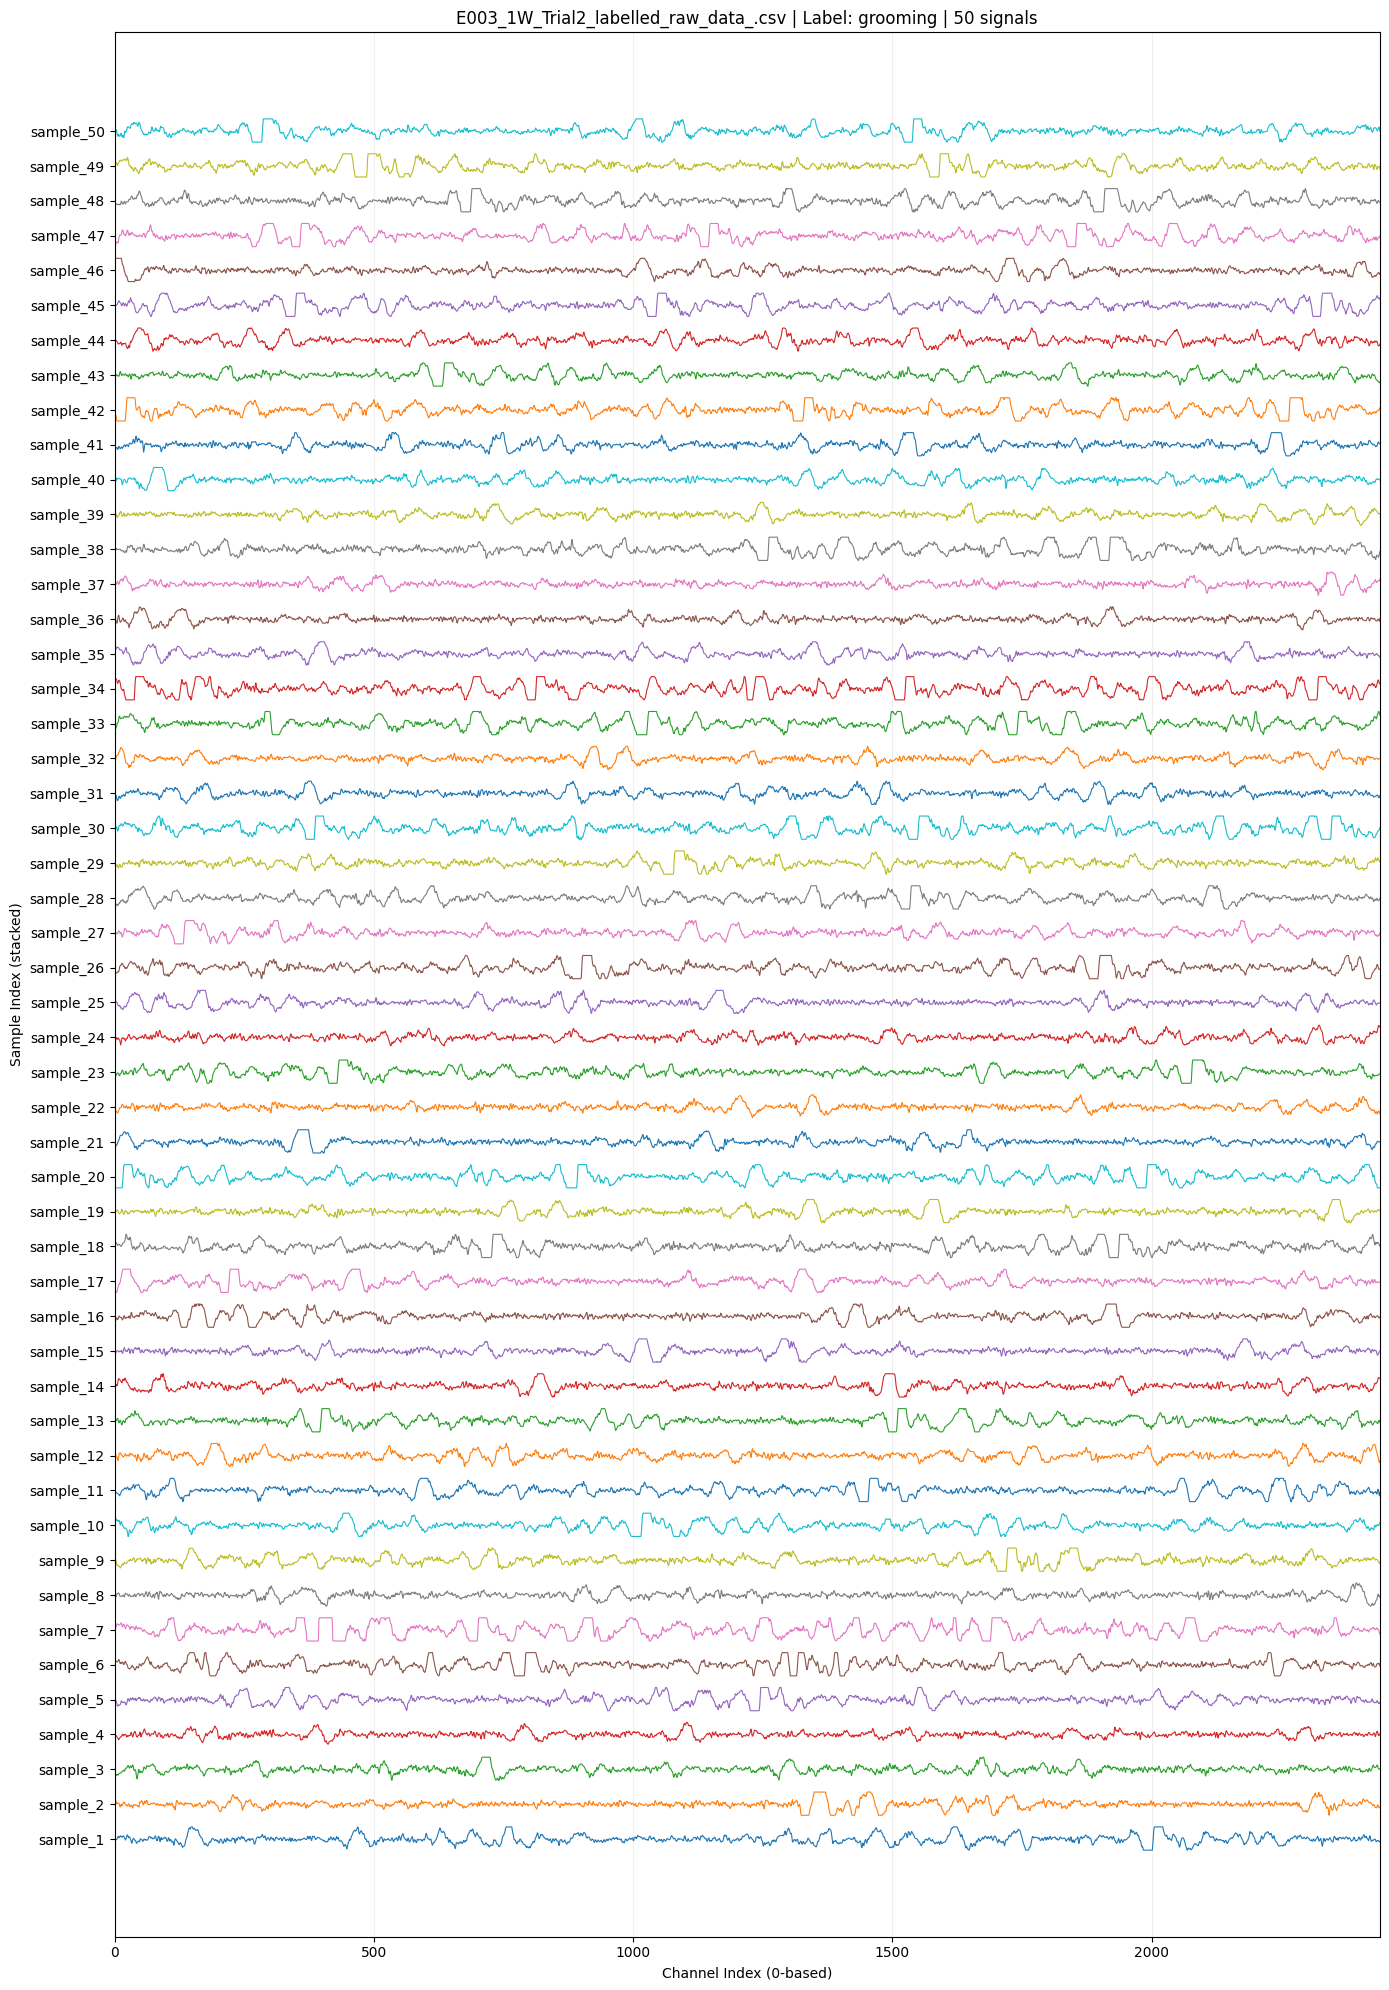

  Saved plot for label grooming -> /media/NAS_179_2_josh_2/snu-pni-decoding/analysis/label_raster_plots/E003_1W_Trial2_labelled_raw_data__label-grooming_raster.png

Totals: 5157 rows -> 5155 after outlier filter -> 5134 final
Finished generating raster plots.


In [72]:
def sanitize_label(label_value: str) -> str:
    """Create filesystem-safe label identifiers."""
    label_str = str(label_value)
    label_str = re.sub(r"[^A-Za-z0-9_-]+", "_", label_str)
    return label_str.strip("_") or "label"

if not target_csv.exists():
    raise FileNotFoundError(f"Selected CSV does not exist: {target_csv}")

print(f"\nGenerating raster plots for {target_csv.name}\n")
df = pd.read_csv(target_csv)

if df.shape[1] < 2:
    raise ValueError("CSV must contain at least two columns (features + label)")

feature_cols = df.columns[:-1]
label_col = df.columns[-1]

features = df[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)
labels = df[label_col]
unique_labels = labels.unique()
resting_labels_lower = {label.lower() for label in resting_labels}
if not resting_labels_lower:
    resting_labels_lower = {"resting"}

# Determine a global percentile range to keep scales consistent
global_low = np.nanpercentile(features.values, y_lim_per_low)
global_high = np.nanpercentile(features.values, y_lim_per_high)
if not np.isfinite(global_low) or not np.isfinite(global_high) or global_low == global_high:
    raise ValueError("Unable to determine global percentile range for features.")
global_range = global_high - global_low
global_mean = np.nanmean(features.values)
global_std = np.nanstd(features.values)
if not np.isfinite(global_std) or global_std == 0:
    raise ValueError("Unable to compute global standard deviation for activity threshold.")
activity_delta = activity_sigma_mult * global_std

print(f"Found {len(unique_labels)} unique labels: {unique_labels}")

total_rows_all = len(features)
after_outlier_all = 0
after_spike_all = 0

for label_value in unique_labels:
    label_mask = labels == label_value
    label_rows = features[label_mask]
    total_rows = len(label_rows)
    if label_rows.empty:
        continue

    label_key = str(label_value).lower()
    numeric_rows = label_rows.to_numpy()

    outlier_mask = np.any(np.abs(numeric_rows - global_mean) >= outlier_sigma_mult * global_std, axis=1)
    if outlier_mask.any():
        label_rows = label_rows.iloc[~outlier_mask]
        numeric_rows = numeric_rows[~outlier_mask]
        if label_rows.empty:
            print(f"  Skipping label '{label_value}' (all {total_rows} rows flagged as extreme outliers)")
            continue

    filtered_rows = len(label_rows)
    after_outlier_all += filtered_rows

    if label_key not in resting_labels_lower:
        spike_counts = (np.abs(numeric_rows - global_mean) >= activity_delta).sum(axis=1)
        spike_mask = spike_counts >= min_spike_count
        if not spike_mask.any():
            print(f"  Skipping label '{label_value}' (no rows meet firing-rate threshold; {filtered_rows}/{total_rows} rows after outlier filter)")
            continue
        label_rows = label_rows.iloc[spike_mask]
        numeric_rows = numeric_rows[spike_mask]

    kept_rows = len(label_rows)
    after_spike_all += kept_rows
    print(f"Label '{label_value}': {total_rows} rows -> {kept_rows} after filtering")

    n_rows = min(sample_num, len(label_rows))
    sampled = (
        label_rows.sample(n=n_rows, random_state=random_state)
        if len(label_rows) > n_rows
        else label_rows
    )
    signals = sampled.to_numpy()
    signals = np.clip(signals, global_low, global_high)

    offsets = np.arange(n_rows) * global_range * vertical_scale

    fig_height = max(3, n_rows * 0.4)
    fig, ax = plt.subplots(figsize=(14, fig_height))
    for idx, signal in enumerate(signals):
        ax.plot(signal + offsets[idx], linewidth=0.8)

    ax.set_title(f"{target_csv.name} | Label: {label_value} | {n_rows} signals", fontsize=12)
    ax.set_xlabel("Channel Index (0-based)")
    ax.set_ylabel("Sample Index (stacked)")
    ax.set_xlim(0, signals.shape[1] - 1)
    ax.set_yticks(offsets)
    ax.set_yticklabels([f"sample_{i+1}" for i in range(n_rows)])
    ax.grid(True, axis='x', alpha=0.2)
    fig.tight_layout()

    outfile = output_dir / f"{target_csv.stem}_label-{sanitize_label(label_value)}_raster.png"
    fig.savefig(outfile, dpi=150)
    plt.show()
    plt.close(fig)
    print(f"  Saved plot for label {label_value} -> {outfile}")

print(f"\nTotals: {total_rows_all} rows -> {after_outlier_all} after outlier filter -> {after_spike_all} final")
print("Finished generating raster plots.")
